# B_Cleaning

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import scipy.stats as stats

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import regex as re

import plotly.plotly as py
import plotly.tools as pytools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as pyo
import cufflinks as cf

pytools.set_credentials_file(username='katerdowdy', api_key='hBCWsR3iY9a1feRSpU2A')

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

%matplotlib inline

np.random.seed(42)

CSVs retrieved from Ben Schoenfeld's website 'Virginia Court Data': http://virginiacourtdata.org/.

In [2]:
df1 = pd.read_csv('./data/district_criminal_2017_anon_00.csv')
df2 = pd.read_csv('./data/district_criminal_2017_anon_01.csv')
df3 = pd.read_csv('./data/district_criminal_2017_anon_02.csv')
df4 = pd.read_csv('./data/district_criminal_2017_anon_03.csv')
df5 = pd.read_csv('./data/district_criminal_2017_anon_04.csv')
df6 = pd.read_csv('./data/district_criminal_2017_anon_05.csv')
df7 = pd.read_csv('./data/district_criminal_2017_anon_06.csv')
df8 = pd.read_csv('./data/district_criminal_2017_anon_07.csv')
df9 = pd.read_csv('./data/district_criminal_2017_anon_08.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3,29,32) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (29,32) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
df_full = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

In [4]:
df_full.shape

(2100530, 42)

In [5]:
df_full.columns

Index(['HearingDate', 'HearingResult', 'HearingPlea', 'HearingContinuanceCode',
       'HearingType', 'HearingCourtroom', 'fips', 'FiledDate', 'Locality',
       'Status', 'DefenseAttorney', 'Address', 'Gender', 'Race', 'Charge',
       'CodeSection', 'CaseType', 'Class', 'OffenseDate', 'ArrestDate',
       'Complainant', 'AmendedCharge', 'AmendedCode', 'AmendedCaseType',
       'FinalDisposition', 'SentenceTime', 'SentenceSuspendedTime',
       'ProbationType', 'ProbationTime', 'ProbationStarts',
       'OperatorLicenseSuspensionTime', 'RestrictionEffectiveDate',
       'RestrictionEndDate', 'OperatorLicenseRestrictionCodes', 'Fine',
       'Costs', 'FineCostsDue', 'FineCostsPaid', 'FineCostsPaidDate', 'VASAP',
       'FineCostsPastDue', 'person_id'],
      dtype='object')

#### Dropping Hearings after 2017

In [6]:
df_full['HearingDate'] = pd.to_datetime(df_full['HearingDate'])
df_full[df_full['HearingDate'] > '2017-12-31'].sort_values(by='HearingDate', ascending = False).shape

(190902, 42)

In [7]:
df_full = df_full[df_full['HearingDate'] <= '2017-12-31']

#### Dropping Rows Where 'Final Disposition' is Null

In [8]:
df_full['FinalDisposition'].isnull().sum()

1529

In [9]:
df_full.dropna(subset = ['FinalDisposition'], inplace = True)

In [10]:
df_full.shape

(1908099, 42)

#### Dropping Rows Where 'Hearing Result' is 'Continued'

In [11]:
df_full['HearingResult'].value_counts()

Finalized    1322417
Waived        585424
Continued        206
Name: HearingResult, dtype: int64

In [12]:
df_full = df_full[df_full['HearingResult'] != 'Continued']

In [13]:
df_all = df_full

#### Checking Nulls in Other Columns

In [14]:
df_full.isnull().sum()

HearingDate                              0
HearingResult                           52
HearingPlea                        1552658
HearingContinuanceCode             1888842
HearingType                        1012455
HearingCourtroom                    986460
fips                                     0
FiledDate                                0
Locality                                80
Status                              281812
DefenseAttorney                    1489334
Address                                  4
Gender                                   0
Race                                 14092
Charge                                   0
CodeSection                              6
CaseType                                 0
Class                              1503330
OffenseDate                              0
ArrestDate                         1622545
Complainant                             32
AmendedCharge                      1738403
AmendedCode                        1738419
AmendedCase

##### Reset Index

In [15]:
df_full.reset_index(inplace = True)

## Custom Features

#### Had Lawyer

In [16]:
df_full['DefenseAttorney'].fillna(0, inplace = True)

In [17]:
df_full['HadLawyer'] = [1 if x != 0 else 0 for x in df_full['DefenseAttorney']]

In [18]:
df_full['HadLawyer'].value_counts()

0    1489334
1     418559
Name: HadLawyer, dtype: int64

##### Hired Public Defender

In [19]:
def public_defender(x):
    string = str(x).upper()
    if re.findall(r"((PUBLIC DEFENDER)|(P/D)|(PD)|( DEF)|(DEFENDER)|[P][.][D])", string):
        return 1        
    else:
        return 0

In [20]:
df_full['PublicDefender'] = df_full['DefenseAttorney'].apply(lambda x: public_defender(x))

In [21]:
df_full['PublicDefender'].value_counts(normalize = True)

0    0.96249
1    0.03751
Name: PublicDefender, dtype: float64

In [22]:
# checking that caught the public defenders
df_full[df_full['PublicDefender'] == 0]['DefenseAttorney'].value_counts().head(10)

0                       1489334
PENDLETON                  2993
FRENCH, JENNIFER           1654
CLARY                      1450
PENDLETON, CHRISTINA       1194
REMINGTON                  1063
KEGLEY, CLINTON            1015
JURACH, ADAM                886
MARTIN                      858
ROBINSON                    856
Name: DefenseAttorney, dtype: int64

In [23]:
# checking that caught the public defenders
df_full[df_full['PublicDefender'] == 1]['DefenseAttorney'].value_counts().head(10)

PUBLIC DEFENDER                  24423
PD                               19038
PUBLIC DEFENDER 703-934-5600      4627
PUB DEF                           2962
P DEF                             2551
P/D                               2265
PUBLIC DEFENDER  703-934-5600     2200
PUBLIC DEFENDER (TSR)             1510
PUBLIC DEFENDER(TSR)              1424
PD/GIESSUEBEL                      477
Name: DefenseAttorney, dtype: int64

##### Went to Court

In [24]:
df_full['FinalDisposition'].value_counts()

Prepaid                                      556402
Guilty                                       459897
Guilty In Absentia                           379599
Dismissed                                    225357
Nolle Prosequi                               133019
Certified To Grand Jury                       48684
Complied With Law                             38629
Not Guilty                                    24854
Fugitive File                                 17748
Certified Misdemeanor                          8013
Transferred To Another Jurisdiction/Court      4588
Other                                          4536
Defendant Not Found                            1952
Granted                                        1908
Sentence/Probation Revoked                     1392
Extradition Waived                             1085
Dismissed/Other                                 118
Denied                                           95
Extradition Ordered                               7
Not Guilty/I

In [25]:
no_contest = ['Prepaid', 'Guilty In Absentia']

In [26]:
df_full['Contested'] = [0 if x in no_contest else 1 for x in df_full['FinalDisposition']]

In [27]:
df_full['Contested'].value_counts(normalize = True)

1    0.509406
0    0.490594
Name: Contested, dtype: float64

#####  Positive Outcome for Defense

In [28]:
defense_positive = ['Dismissed', 
                    'Nolle Prosequi', 
                    'Not Guilty', 
                    'Complied With Law', 
                    'Sentence/Probation Revoked',
                   'Not Guilty/Insanity']

In [29]:
df_full['Outcome_Positive'] = [1 if x in defense_positive else 0 for x
                               in df_full['FinalDisposition']]

In [30]:
df_full['Outcome_Positive'].value_counts(normalize = True)

0    0.778155
1    0.221845
Name: Outcome_Positive, dtype: float64

##### Amended

In [31]:
df_full['AmendedCharge'].fillna('0', inplace = True)

In [32]:
df_full['Amended'] = [1 if x != '0' else 0 for x in df_full['AmendedCharge']]

In [33]:
df_full['Amended'].value_counts(normalize = True)

0    0.911164
1    0.088836
Name: Amended, dtype: float64

##### Positive or Amended

In [34]:
df_full['Total_Positive'] = df_full['Outcome_Positive'] + df_full['Amended']

In [35]:
df_full['Total_Positive'].value_counts(normalize = True)

0    0.691223
1    0.306872
2    0.001905
Name: Total_Positive, dtype: float64

In [36]:
df_full['Total_Positive'].replace(2, 1, inplace = True)

#### Plea

In [37]:
df_full['HearingPlea'].value_counts()

Tried In Absentia    144858
Guilty               119720
Not Guilty            57538
Nolo Contendere       33119
Name: HearingPlea, dtype: int64

In [38]:
df_full['HearingPlea'].fillna('Unknown', inplace = True)

In [39]:
# checking to see if there are any major categories where plea might be usable, doesn't look like it
df_full.groupby('CaseType')['HearingPlea'].value_counts(normalize = True)

CaseType                                               HearingPlea      
Capias                                                 Unknown              0.859758
                                                       Guilty               0.068631
                                                       Not Guilty           0.051568
                                                       Nolo Contendere      0.016746
                                                       Tried In Absentia    0.003297
Civil Violation                                        Unknown              0.887892
                                                       Not Guilty           0.049514
                                                       Guilty               0.037369
                                                       Tried In Absentia    0.018124
                                                       Nolo Contendere      0.007100
Felony                                                 Unknown              0

#### Multiple Charges for One Person

In [40]:
dates = df_full['HearingDate'].unique()
len(dates)

246

In [41]:
defendees = df_full['person_id'].unique()
len(defendees)

1207807

In [42]:
# all hearings in 2017 per person
df_full['person_id_freq'] = df_full.groupby('person_id')['person_id'].transform('count')

In [43]:
df_full = df_full.sort_values(by = 'HearingDate', ascending = True)
df_full.reset_index(inplace = True)

In [44]:
# just prior hearings per person 2017
df_full['prior_hearings'] = df_full.groupby('person_id').cumcount()

In [45]:
df_full.head()

,level_0,index,HearingDate,HearingResult,HearingPlea,HearingContinuanceCode,HearingType,HearingCourtroom,fips,FiledDate,Locality,Status,DefenseAttorney,Address,Gender,Race,Charge,CodeSection,CaseType,Class,OffenseDate,ArrestDate,Complainant,AmendedCharge,AmendedCode,AmendedCaseType,FinalDisposition,SentenceTime,SentenceSuspendedTime,ProbationType,ProbationTime,ProbationStarts,OperatorLicenseSuspensionTime,RestrictionEffectiveDate,RestrictionEndDate,OperatorLicenseRestrictionCodes,Fine,Costs,FineCostsDue,FineCostsPaid,FineCostsPaidDate,VASAP,FineCostsPastDue,person_id,HadLawyer,PublicDefender,Contested,Outcome_Positive,Amended,Total_Positive,person_id_freq,prior_hearings
0,1198335,99912,2017-01-03,Finalized,Nolo Contendere,NaN,Review Progress,TJK,13,2016-02-03,COMMONWEALTH OF VA,Bail,PUBLIC DEFENDER,"WASHINGTON, DC 20001",Male,Black(Non-Hispanic),FAIL TO APPEAR,19.2-128,Capias,1,2016-02-02,2016-05-26,COMMONWEALTH OF VIRGINIA,0,NaN,NaN,Guilty,5.0,5.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,91.0,NaN,t,2017-03-31,NaN,NaN,138060000000108,1,1,1,0,0,0,3,0
1,655285,5409,2017-01-03,Finalized,Unknown,NaN,NaN,NaN,193,2016-08-08,COMMONWEALTH OF VA,NaN,0,"CALLAO, VA 22435",Male,Hispanic,FAIL DRIVE RT SIDE OF HIGHWAY,46.2-802,Infraction,NaN,2016-07-31,2016-07-31,SNYDER,0,NaN,NaN,Nolle Prosequi,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273110000000070,0,0,1,1,0,1,4,0
2,655279,5401,2017-01-03,Finalized,Unknown,NaN,Arraignment,NaN,193,2016-08-08,COMMONWEALTH OF VA,Released On Summons,MONROE,"CALLAO, VA 22435",Male,Hispanic,DRIV UNDER REVO/SUSPENSION,B.46.2-301,Misdemeanor,NaN,2016-07-31,NaN,SNYDER,0,NaN,NaN,Guilty,60.0,60.0,Unsupervised Probation,1095.0,NaN,90.0,NaN,NaN,NaN,100.0,179.0,2017-01-03,NaN,NaN,NaN,t,273110000000070,1,0,1,0,0,0,4,1
3,655271,5390,2017-01-03,Finalized,Unknown,NaN,Arraignment,NaN,193,2017-01-03,COMMONWEALTH OF VA,Released On Summons,0,"COLONIAL BEACH, VA 22443",Male,White Caucasian(Non-Hispanic),FELONY POSSESSION OF DRUGS,18.2-248,Felony,NaN,2016-05-13,NaN,CIRCUIT COURT,0,NaN,NaN,Transferred To Another Jurisdiction/Court,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287050000000124,0,0,1,0,0,0,1,0
4,655267,5385,2017-01-03,Finalized,Unknown,NaN,Arraignment,NaN,193,2016-12-22,COMMONWEALTH OF VA,Released On Summons,MONROE,"COLONIAL BEACH, VA 22443",Male,White Caucasian(Non-Hispanic),VIOLATE PRE-TRIAL RELEASE,19.2-123,Capias,NaN,2016-12-21,NaN,PRE-TRIAL,0,NaN,NaN,Guilty,0.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201020000000439,1,0,1,0,0,0,3,0


#### Time Since Offense

In [46]:
df_full['HearingDate'] = pd.to_datetime(df_full['HearingDate'])

In [47]:
df_full['OffenseDate'] = pd.to_datetime(df_full['OffenseDate'])

In [48]:
df_full['TimeSinceOffense'] = df_full['HearingDate'] - df_full['OffenseDate']

# fixing format
df_full['TimeSinceOffense'] = df_full['TimeSinceOffense'].astype(str)

def clean(x):
    day = x.split(" ")[0]
    return int(day)

df_full['TimeSinceOffense'] = df_full['TimeSinceOffense'].apply(lambda x: clean(x))

In [49]:
df_full['TimeSinceOffense'].value_counts().head()

42    33344
41    32971
47    31718
46    31415
43    29454
Name: TimeSinceOffense, dtype: int64

#### Race Columns

In [50]:
df_full['Race'].value_counts()

White Caucasian(Non-Hispanic)                 1139157
Black(Non-Hispanic)                            600232
Hispanic                                        61904
Other(Includes Not Applicable, Unknown)         39168
Asian Or Pacific Islander                       35647
Unknown (Includes Not Applicable, Unknown)      14587
American Indian                                  3106
Name: Race, dtype: int64

In [51]:
df_full['Race'].replace({'Unknown (Includes Not Applicable, Unknown)': 
                     'Other(Includes Not Applicable, Unknown)'}, inplace = True)

In [52]:
df_full['Race'].replace({'0': 
                     'Other(Includes Not Applicable, Unknown)'}, inplace = True)

#### Fips Codes/Districts

In [53]:
df_full['fips'].unique()

array([ 13, 193,  59, 143, 830, 800, 570, 195,  35, 199, 177,  41,  87,
        85, 183, 155,  71, 141,  51, 740, 595, 680,  69, 711, 550,  65,
       620, 117, 147,  81,  15, 520, 121, 761, 670, 810, 109, 820, 770,
       187, 630, 762, 191,  83, 730,  89, 181, 540,   9,  31, 510, 165,
       127, 712, 171, 775, 764,  45, 702, 153, 790, 175, 197, 600,   3,
       107, 169,   5, 701, 131, 157,   7, 650, 590, 179,  33,  47,  19,
       690,  67,  11, 125, 135, 103, 173, 137,  93,  23, 840,  73, 149,
        25,  21,   1,  17, 163,  36,  99,  91, 185, 105,  79,  43, 161,
       111,  61, 610,  53,  49, 530, 113, 167,  63,  37, 101, 139,  27,
        57,  29, 145, 159,  97,  75,  77, 640, 133, 115, 750, 119, 710,
       122, 703])

In [54]:
fips_map1 = {
    1:     'Accomack County',
    3:     'Albemarle County',
    510:   'Alexandria City',
    5:     'Alleghany County',
    7:     'Amelia County',
    9:     'Amherst County',
    11:    'Appomatox County',
    13:    'Arlington County',
    15:    'Augusta County',
    17:    'Bath County',
    19:    'Bedford County',
    515:   'Bedford City',
    21:    'Bland County',
    23:    'Botetourt County',
    520:   'Bristol City',
    25:    'Brunswick County',
    27:    'Buchanan County',
    29:    'Buckingham County',
    530:   'Buena Vista City',
    31:    'Campbell County',
    33:    'Caroline County',
    35:    'Carroll County',
    36:    'Charles City County',
    37:    'Charlotte County',
    540:   'Charlottesville City',
    550:   'Chesapeake City',
    41:    'Chesterfield County',
    43:    'Clarke County',
    570:   'Colonial Heights City',
    580:   'Covington City',
    45:    'Craig County',
    47:    'Culpeper County',
    49:    'Cumberland County',
    590:   'Danville City',
    51:    'Dickenson County',
    53:    'Dinwiddie County',
    595:   'Emporia City',
    57:    'Essex County',
    59:    'Fairfax County',
    600:   'Fairfax City',
    610:   'Falls Church City',
    61:    'Fauquier County',
    63:    'Floyd County',
    65:    'Fluvanna County',
    67:    'Franklin County', 
    620:   'Franklin City',
    69:    'Frederick County',
    630:   'Fredericksburg City',
    640:   'Galax City',
    71:    'Giles County',
    73:    'Gloucester County',
    75:    'Goochland County',
    77:    'Grayson County',
    79:    'Greene County',
    81:    'Greensville County',
    83:    'Halifax County',
    650:   'Hampton City',
    85:    'Hanover County',
    660:   'Harrisonburg City',
    87:    'Henrico County',
    89:    'Henry County',
    91:    'Highland County',
    670:   'Hopewell City',
    93:    'Isle of Wight County',
    95:    'James City County',
    99:    'King George County',
    97:    'King and Queen County',
    101:   'King William County',
    103:   'Lancaster County',
    105:   'Lee County',
    678:   'Lexington City',
    107:   'Loudoun County',
    109:   'Louisa County',
    111:   'Lunenburg County',
    680:   'Lynchburg City',
    113:   'Madison County',
    683:   'Manassas City',
    685:   'Manassas Park City',
    690:   'Martinsville City',
    115:   'Mathews County',
    117:   'Mecklenburg County',
    119:   'Middlesex County',
    121:   'Montgomery County',
    125:   'Nelson County',
    127:   'New Kent County',
    700:   'Newport News City',
    710:   'Norfolk City',
    131:   'Northampton County',
    133:   'Northumberland County',
    720:   'Norton City',
    135:   'Nottoway County',
    137:   'Orange County',
    139:   'Page County',
    141:   'Patrick County',
    730:   'Petersburg City',
    143:   'Pittsylvania County',
    735:   'Poquoson City',
    740:   'Portsmouth City',
    145:   'Powhatan County',
    147:   'Prince Edward County',
    149:   'Prince George County',
    153:   'Prince William County',
    155:   'Pulaski County',
    750:   'Radford City',
    157:   'Rappahannock County',
    159:   'Richmond County',
    760:   'Richmond City',
    161:   'Roanoke County',
    770:   'Roanoke City',
    163:   'Rockbridge County',
    165:   'Rockingham County',
    167:   'Russell County',
    775:   'Salem City',
    169:   'Scott County',
    171:   'Shenandoah County',
    173:   'Smyth County',
    175:   'Southampton County',
    177:   'Spotsylvania County',
    179:   'Stafford County',
    790:   'Staunton City',
    800:   'Suffolk City',
    181:   'Surry County',
    183:   'Sussex County',
    185:   'Tazewell County',
    810:   'Virginia Beach City',
    187:   'Warren County',
    191:   'Washington County',
    820:   'Waynesboro City',
    193:   'Westmoreland County',
    830:   'Williamsburg City',
    840:   'Winchester City',
    195:   'Wise County',
    197:   'Wythe County',
    199:   'York County',
    # codes below aren't official, but guessed based on looking at addresses and medium post:
    # https://medium.com/@virginiacourtdata/are-speed-limits-not-enforced-in-this-area-f0c3c594adb4
    701:   'Newport News City', 
    702:   'Newport News City', 
    703:   'Newport News City',
    711:   'Norfolk City',
    712:   'Norfolk City',
    761:   'Richmond City',
    762:   'Richmond City',
    764:   'Richmond City',
    122:   'Montgomery County'
}

In [55]:
fips_map2 = {51762: 51760, 
            51761: 51760, 
            51702: 51700,
            51764: 51760, 
            51712: 51710, 
            51711: 51710, 
            51701: 51700, 
            51703: 51700, 
            51122: 51121}

In [56]:
df_full['Court'] = df_full['fips'].map(fips_map1) 
df_full['fips'].replace(fips_map2, inplace = True) # correcting other codes

In [57]:
df_full['Court'].value_counts().head(15)

Fairfax County           219764
Prince William County     78133
Virginia Beach City       77971
Henrico County            69050
Chesterfield County       58283
Chesapeake City           52088
Norfolk City              48675
Loudoun County            46360
Richmond City             45040
Arlington County          40394
Newport News City         39691
Hampton City              35257
Alexandria City           31227
Rockingham County         28193
Wythe County              27833
Name: Court, dtype: int64

In [58]:
# creating usable fips column for chloropleth
def full_fips(fips):
    str_fips = str(fips)
    if len(str_fips) == 1:
        return int('5100' + str_fips)
    if len(str_fips) == 2:
        return int('510' + str_fips)
    elif len(str_fips) == 3:
        return int('51' + str_fips)
    
df_full['full_fips'] = df_full['fips'].apply(lambda x: full_fips(x))
df_full.groupby('full_fips')['full_fips'].count().sort_values(ascending = False).head()

full_fips
51059    219764
51153     78133
51810     77971
51087     69050
51041     58283
Name: full_fips, dtype: int64

#### Cleaning Lawyer Column

In [59]:
def clean_lawyers(string):
    letters_only = re.sub("[^a-zA-Z]", "", string) # remove non-letters
    lower = letters_only.lower() # convert to lowercase
    return lower

df_full['DefenseAttorney'] = df_full['DefenseAttorney'].apply(lambda x: clean_lawyers(str(x)))

df_full[df_full['Court'] == 'Fairfax County']['DefenseAttorney'].value_counts()

                             180386
publicdefender                 7087
sarsourjad                     1383
greengarrett                    562
kerseyandrew                    466
rambudhanryan                   466
wallcarlos                      413
dyciomark                       409
manikaskyle                     348
mcglonepaul                     303
yoonjoseph                      303
oatesjonathan                   300
salvadoalberto                  294
dearbornrobert                  289
robinsonmichael                 255
beckwithgregory                 242
letnickjeremy                   236
smithronald                     236
zinicolatodd                    229
nourseanthony                   220
bonetajohn                      218
smitherin                       212
hicksbr                         211
halldavid                       201
nerinomary                      187
rosenthallfaraji                181
duaraj                          178
syrianirana                 

## Clustering Charges

##### Separating by CaseType

In [60]:
# Infractions
print("Unique Infraction Charges:", 
      df_full[df_full['CaseType'] == 'Infraction']['Charge'].nunique())
print("Unique Infraction CodeSections", 
     df_full[df_full['CaseType'] == 'Infraction']['CodeSection'].nunique())

Unique Infraction Charges: 25204
Unique Infraction CodeSections 1122


In [61]:
# Civil Violations
print("Unique Civil Violation Charges:", 
      df_full[df_full['CaseType'] == 'Civil Violation']['Charge'].nunique())
print("Unique Civil Violation CodeSections", 
     df_full[df_full['CaseType'] == 'Civil Violation']['CodeSection'].nunique())

Unique Civil Violation Charges: 61
Unique Civil Violation CodeSections 58


In [62]:
# Misdemeanors
print("Unique Misdemeanor Charges:", 
      df_full[df_full['CaseType'] == 'Misdemeanor']['Charge'].nunique())
print("Unique Misdemeanor CodeSections", 
     df_full[df_full['CaseType'] == 'Misdemeanor']['CodeSection'].nunique())

Unique Misdemeanor Charges: 34709
Unique Misdemeanor CodeSections 4128


In [63]:
# Felonies
print("Unique Felony Charges:", 
      df_full[df_full['CaseType'] == 'Felony']['Charge'].nunique())
print("Unique Felony CodeSections", 
     df_full[df_full['CaseType'] == 'Felony']['CodeSection'].nunique())

Unique Felony Charges: 6660
Unique Felony CodeSections 314


I started using Virginia's Law Code lookup (https://law.lis.virginia.gov/vacode) to see what kind of charges were being filed, but quickly found some of the codes in the dataframe don't exist in the online lookup. Instead of hunting down the right codes, I decided to use LDA on the 'Charge' field to come up with common categories for Infractions, Misdemeanors, Felonies, and Civil Violations.

### Topic Modeling for Case Types

##### Civil Violations

In [64]:
def clean_strings(string):
    short = string.strip("CIVIL VIOLATION - ")
    letters_only = re.sub("[^a-zA-Z]", " ", short) # remove non-letters
    lower = letters_only.lower() # convert to lowercase
    return lower

In [65]:
civil_violation_charges = df_full[df_full['CaseType'] == 
                                  'Civil Violation']['Charge'].apply(lambda x: clean_strings(str(x)))

In [66]:
df_full[df_full['CaseType'] == 'Civil Violation']['Charge'].value_counts().head()

CIVIL VIOLATION - REFUSED BLOOD/BREATH TEST       4358
CIVIL VIOLATION - NO BOATING EDUCATION CERT        311
CIVIL VIOLATION - SMOKE W/MINOR < 8 IN VEHICLE     201
CIVIL VIOLATION - CIVIL; DANGEROUS DOG             127
CIVIL VIOLATION - PARK/USE DGIF PROP W/O FEE        64
Name: Charge, dtype: int64

In [67]:
# instantiate vectorizer, guessing 5 'topics' based on charge value counts
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(2, 4))
X = tfidf.fit_transform(civil_violation_charges)

lda   = LatentDirichletAllocation(n_components=5, learning_method="batch", max_iter = 20, 
                                  random_state=42)
model = lda.fit(X)

feature_names = tfidf.get_feature_names()

In [68]:
# code from https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [69]:
no_top_words =15
display_topics(model, feature_names, no_top_words)

Topic 0
blood breath tes breath tes refused blood breath tes refused blood breath refused blood blood breath uisance anim fail prod weapon prod weapon perm fail prod fail prod weapon perm weapon perm prod weapon refused blood breath test blood breath test
Topic 1
dogs livestock vicious dog refused blood breath test breath test blood breath test run large dog run large dog run lanes viol hot lanes hot lanes viol public nuisance dog license smoking non public non public
Topic 2
education cer boating education boating education cer sell minor prop fee park use dgif prop park use dgif park use dgif prop dgif prop fee use dgif prop fee use dgif prop use dgif fishing license fail required boaters
Topic 3
smoke minor vehicle smoke minor minor vehicle smoking vio vio restaur smoking vio restaur impound anim seize impound seize impound anim animal steriliz uisance dog helmet skating extingquisher required inoperable vehicle failure register
Topic 4
dangerous dog subq yrs refuse blood subq yrs b

In [70]:
# mapping new charge topics column based on words from LDA
def topic_civilviol(string):
    string = string.lower()
    if re.findall(r"(dog|animal|impound|livestock)", string):
        return 'VIOL: Animal Violations'
    elif re.findall(r"(refuse|blood|test)", string):
        return 'VIOL: Refused Blood/Breathalizer Test'
    elif re.findall(r"(boating|education)", string):
        return 'VIOL: Boating Certification Issue'
    elif re.findall(r"(smoke|smoking)", string):
        return 'VIOL: Smoking Violation'
    else:
        return 'VIOL: Other'

In [71]:
df_full['ChargeType'] = df_full[df_full['CaseType'] == 
                                 'Civil Violation']['Charge'].apply(lambda x: topic_civilviol(str(x)))

In [72]:
df_full['ChargeType'].value_counts()

VIOL: Refused Blood/Breathalizer Test    4385
VIOL: Boating Certification Issue         312
VIOL: Animal Violations                   275
VIOL: Smoking Violation                   253
VIOL: Other                               127
Name: ChargeType, dtype: int64

In [73]:
# went back to see if there were any other major categories not covered within 'Other'
df_full[df_full['ChargeType'] == 'VIOL: Other']['Charge'].value_counts().head()

CIVIL VIOLATION - PARK/USE DGIF PROP W/O FEE     64
CIVIL VIOLATION - CIVIL; SELL TO MINOR           33
CIVIL VIOLATION - CIVIL; SELL W/O REQUIRED ID     4
CIVIL VIOLATION - HOT LANES VIOL 1ST              3
CIVIL VIOLATION - FAIL TO PROD WEAPON PERMIT      2
Name: Charge, dtype: int64

##### Infractions

In [74]:
df_full[df_full['CaseType'] == 'Infraction']['Charge'].value_counts().head(10)

FAIL TO HAVE VEHICLE INSPECTED    96660
FAIL TO OBEY HIGHWAY SIGN         67401
EXPIRED REGISTRATION              49130
SAFETY BELT VIOLATION             31018
OPERATE/PERMT OP UNLIC MTR VEH    28223
80/70 SP                          23781
DEFECTIVE EQUIPMENT GENERALLY     23519
FAIL STOP/YIELD ENTERING HWY      19006
FOLLOWING TOO CLOSELY             18431
FAIL TO OBEY TRAFFIC SIGNAL       18418
Name: Charge, dtype: int64

In [75]:
def clean_infraction(string):
    lower = string.lower() # converting all to lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", lower) # remove non-letters
    return letters_only

In [76]:
# clean text
infraction_charges = df_full[df_full['CaseType'] == 
                                  'Infraction']['Charge'].apply(lambda x: clean_infraction(str(x)))

In [77]:
# instantiating tfidf
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(2, 4))
X = tfidf.fit_transform(infraction_charges)

lda   = LatentDirichletAllocation(n_components=15, learning_method="batch", max_iter = 10, 
                                  random_state=42, n_jobs = -2)
model = lda.fit(X)

feature_names = tfidf.get_feature_names()

In [78]:
no_top_words =15
display_topics(model, feature_names, no_top_words)

Topic 0
child restraint op tint signs decals tint signs op tint signs tint signs decals op tint signs decals decals windows signs decals windows tint signs decals windows hov violation uninspected vehicle oper uninspected oper uninspected vehicle tail lights
Topic 1
defective equipment equipment generally defective equipment generally improper turn expired rejection hov viol rejection sticker expired rejection sticker hov viol st st plan st plan dist hov viol st plan viol st plan dist viol st plan plan dist
Topic 2
fail stop stop yield fail stop yield yield entering yield entering hwy stop yield entering fail stop yield entering stop yield entering hwy entering hwy exp tags flashing lights vio flashing vehicle vio vio flashing lights vehicle vio flashing
Topic 3
belt violation safety belt violation safety belt defective speedometer highway marking obey highway marking fail obey highway marking obey highway fail obey highway fail obey turn red right turn right turn red violation right v

In [79]:
def topic_infraction(string):
    string = string.lower()
    if re.findall(r"(expire|exp|fail to have vehicle)", string):
        return 'INF: Expired Registration/Inspection'
    elif re.findall(r"(speed|sp)", string):
        return 'INF: Speeding'
    elif re.findall(r"(restraint|restrnt|belt|seatbe)", string):
        return 'INF: Seatbelt'
    elif re.findall(r"(tint|windshield)", string):
        return 'INF: Tinted Windows/Windshield Issues'
    elif re.findall(r"(red|light|stop)", string):
        return 'INF: Failure to Stop'
    elif re.findall(r"(sign|obey|yield)", string):
        return 'INF: Failure to Yield/Obey Highway Sign'
    elif re.findall(r"(license|lic|ol|o.l.|o/l|plate|tag|title|registration|reg|permit|sticker|unlic)", string):
        return 'INF: License/Permit/Tag Issues'
    elif re.findall(r"(following|drive|close|stopping|turn|brake|braking|lane|passing)", string):
        return 'INF: Bad Driving'
    elif re.findall(r"(defective|improper|insufficient|equip)", string):
        return 'INF: Defective/Illegal Equipment'
    elif re.findall(r"(fail pay full time|fail to pay|fail pay time|fail to correct)", string):
        return 'INF: Failure to Pay On Time/Correct Defects'
    elif re.findall(r"(hov)", string):
        return 'INF: HOV Violation'
    elif re.findall(r"(radar|traff control|traff cont)", string):
        return 'INF: Illegal Radar/Traffic Control Device'
    elif re.findall(r"(txt|earphones|proper control)", string):
        return 'INF: Texting/Earphones/Bad Control While Driving'
    else:
        return 'INF: Other'

In [80]:
infractions_mask = df_full['CaseType'] == 'Infraction'

In [81]:
# mapping to just infractions part of df
df_full.loc[infractions_mask, 'ChargeType'] = df_full[df_full['CaseType'] == 
                      'Infraction']['Charge'].apply(lambda x: topic_infraction(str(x)))

In [82]:
# charge topics up til this point
df_full['ChargeType'].value_counts().head(20)

INF: Speeding                                       522782
INF: Expired Registration/Inspection                189219
INF: Failure to Yield/Obey Highway Sign             131245
INF: License/Permit/Tag Issues                      124315
INF: Failure to Stop                                 57666
INF: Seatbelt                                        48611
INF: Defective/Illegal Equipment                     38861
INF: Bad Driving                                     25473
INF: Tinted Windows/Windshield Issues                23614
INF: Failure to Pay On Time/Correct Defects          19234
INF: Other                                           15012
INF: Illegal Radar/Traffic Control Device             4822
VIOL: Refused Blood/Breathalizer Test                 4385
INF: Texting/Earphones/Bad Control While Driving      2823
INF: HOV Violation                                    2242
VIOL: Boating Certification Issue                      312
VIOL: Animal Violations                                2

In [83]:
# checking, looks like the big topics are accounted for
df_full[df_full['ChargeType'] == 'INF: Other']['Charge'].value_counts()

EXCESSIVE VEHICLE LENGTH          507
UNAUTH USE CROSS OVER HIGHWAY     450
OPER W/O FLAPS                    414
FAIL TO SECURE CHILD              390
INATTENTION                       358
NOT APPR EMERG VEH W/CAUTION      355
OPERATE VEHICLE WITH SUN-SHADI    309
ILLEGL PARK-RESRVD FOR DISABLD    265
WALK IN ROAD-SIDEWLK AVAILABLE    249
VEHICLE MAINTENANCE (GENERAL)     228
OPER ALL TERRAIN VEH ON HGHWAY    228
OPER W/TV SCREEN VISABLE TO DR    223
DISTRACTED DRIVING                128
PEDESTRIAN IMPEDING TRAFFIC       118
SUNSHIELDED WINDOWS               114
TEXTING WHILE DRIVING             105
PHYSICAL QUALIFICATIONS REQ       103
TIRE EXCEEDS WEIGHT LIMIT          97
FAIL TO UPDATE ADDRESS             96
OVER CALIBRATION                   87
EMERGENCY VEH APPROACH W/O CAU     86
FAIL TO MOVE OVER                  85
FAIL TO MAINTAIN LN ACC            84
NO MEDICAL CARD                    84
ILLEGAL EXHAUST                    78
TEXTING WHILE OPERATE VEHICLE      78
UNSAFE PASS-

#### Felonies

In [84]:
df_full[df_full['CaseType'] == 'Felony']['Charge'].value_counts().head(10)

POSS.OF CONTROLLED SUBSTANCE      10135
GRND LARCENY: >=$200 NOT PERSN     7770
MANUF/ETC CONTROLLED SUBSTANCE     4116
OBTAIN CREDIT CARD NO.LARCENY      2303
SALE, DISTRIBUTE MARIJUANA         2209
OBTAIN MONEY FALSE PRET >=$200     2063
ASSLT: ON LAW ENF/DOC PERSON       2034
OTHER FORGERY/UTTERING             1571
OTHER FORGERY, EMPLOY AS TRUE      1446
ENTER HOUSE TO COMMIT A&B ETC.     1386
Name: Charge, dtype: int64

Based on top 10, I'm going to assume 'poss.of controlled substance' is a big category and will remove that string from the text.

In [85]:
def clean_felony(string):
    lower = string.lower() # converting all to lowercase
    remove_stopwords = re.sub("(poss.of controlled substance)", " ", lower)
    letters_only = re.sub("[^a-zA-Z]", " ", remove_stopwords) # remove non-letters
    return letters_only

In [86]:
felony_charges = df_full[df_full['CaseType'] == 
                                  'Felony']['Charge'].apply(lambda x: clean_felony(str(x)))

In [87]:
# instantiating tfidf, picking 25 topics
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(2, 4))
X = tfidf.fit_transform(felony_charges)

lda   = LatentDirichletAllocation(n_components=25, learning_method="batch", max_iter = 10, 
                                  random_state=42, n_jobs = -2)
model = lda.fit(X)

feature_names = tfidf.get_feature_names()

In [88]:
no_top_words =15
display_topics(model, feature_names, no_top_words)

Topic 0
felony warrant fugitive felony warrant fugitive felony bank notes coin bank coin bank notes forging coin forging coin bank forging coin bank notes extort writing habit drive lic drive lic habit drive assault officer fta advisement
Topic 1
felon poss nonviol felon nonviol felon poss nonviol felon poss gun felon poss gun poss gun bad check bad check larceny check larceny violent felon poss tran felon poss tran tran weapon poss tran weapon felon poss tran weapon
Topic 2
asslt law asslt law enf law enf doc enf doc asslt law enf doc enf doc person law enf doc person doc person law enf poss wpn poss wpn ammo wpn ammo felon poss wpn ammo felon poss wpn wpn ammo gun
Topic 3
manuf controlled manuf controlled substance controlled substance theft obtain identy theft obtain id theft obtain id identy theft obtain id identy theft obtain rtrn rental prop fail rtrn rental prop fail rtrn rental fail rtrn rtrn rental rental prop
Topic 4
alter price shoplft alter shoplft alter price pay construc 

In [89]:
def topic_felony(string):
    string = string.lower()
    if re.findall(r"(poss gun|firearm|weapon|wpn|gun|firarm)", string):
        return 'FEL: Illegal Firearm/Weapon'
    elif re.findall(r"(pwid|distribute marijuana|manuf/etc controlled substance|drug sale)", string):
        return 'FEL: Manufacture/Distribute Controlled Substance'
    elif re.findall(r"(controlled substance|poss|cocaine|heroin|obtain drug|methamphetamine)", string):
        return 'FEL: Possessing/Obtaining Drugs'
    elif re.findall(r"(murder)", string):
        return 'FEL: Murder'
    elif re.findall(r"(asslt law|asslt enf|asslt: on law)", string):
        return 'FEL: Assault Law Enforcement Officer'
    elif re.findall(r"(forg|id|extort|false pret|coin|bank|conspiracy|fraud|bad check|identity theft|identy|credit card)", string):
        return 'FEL: Forgery, Fraud, Extortion, Credit Card & Identity Theft'
    elif re.findall(r"(larceny|embezzlement)", string):
        return 'FEL: Larceny/Embezzlement'
    elif re.findall(r"(robbery|shplift|shoplift|stolen|shoplft|stln prprty|petit larceny|pick)", string):
        return 'FEL: Stealing & Petit Larceny'
    elif re.findall(r"(enter|burglary)", string):
        return 'FEL: Burglary & Breaking and Entering'
    elif re.findall(r"(elude|disregard|fugitive|eluding|fail to appear|probation)", string):
        return 'FEL: Fugitive, Avoiding Arrest, Violate Probation'
    elif re.findall(r"(wound|injury|abduct|strangle|assault|shoot|asslt|torture|cruelty)", string):
        return 'FEL: Malicious Injury, Assault & Abduction'
    elif re.findall(r"(sex|porn|rape|sodomy)", string):
        return 'FEL: Rape, Sexual Assault & Child Porn'
    elif re.findall(r"(destruct|fail stop accident|damag)", string):
        return 'FEL: Destruction of Property/Failure to Stop Accident'
    elif re.findall(r"(bomb|burn|threat|arson)", string):
        return 'FEL: Bomb Threat & Arson'
    elif re.findall(r"(dwi|dui)", string):
        return 'FEL: DWI/DUI'
    elif re.findall(r"(flse stmt)", string):
        return 'FEL: False Statement on Criminal History'
    elif re.findall(r"(vehicle|dr|drive|motor)", string):
        return 'FEL: Vehicle-Related'
    else:
        return 'FEL: Other'

In [90]:
felonies_mask = df_full['CaseType'] == 'Felony'

In [91]:
# applying map to felony part of df
df_full.loc[felonies_mask, 'ChargeType'] = df_full[df_full['CaseType'] == 
                      'Felony']['Charge'].apply(lambda x: topic_felony(str(x)))

In [92]:
# charge topics up til this point
df_full['ChargeType'].value_counts()

INF: Speeding                                                   522782
INF: Expired Registration/Inspection                            189219
INF: Failure to Yield/Obey Highway Sign                         131245
INF: License/Permit/Tag Issues                                  124315
INF: Failure to Stop                                             57666
INF: Seatbelt                                                    48611
INF: Defective/Illegal Equipment                                 38861
INF: Bad Driving                                                 25473
INF: Tinted Windows/Windshield Issues                            23614
FEL: Forgery, Fraud, Extortion, Credit Card & Identity Theft     21408
INF: Failure to Pay On Time/Correct Defects                      19234
FEL: Possessing/Obtaining Drugs                                  16848
FEL: Larceny/Embezzlement                                        15989
INF: Other                                                       15012
FEL: M

In [93]:
# checking for additional topics under 'Other' to filter out
df_full[df_full['ChargeType'] == 'FEL: Other']['Charge'].value_counts().head()

VIOL OFF FAIL TO REGIST, 2 OFF    369
ADVANCE PAY, NO CONSTRUC >$200    160
NOT RETURN PROP-BAILEE >=$200     149
OBTAIN DOCUMENTS NOT ENTITLED     135
WEAR MASKS IN CERTAIN PLACES      104
Name: Charge, dtype: int64

#### Misdemeanors

In [94]:
df_full[df_full['CaseType'] == 'Misdemeanor']['Charge'].value_counts().head(5)

DRIV UNDER REVO/SUSPENSION      36340
NO DRIVERS LICENSE              31701
POSSESSION OF MARIJUANA         23529
PUBLIC SWEARING/INTOXICATION    15562
DWI, 1ST                        10793
Name: Charge, dtype: int64

In [95]:
def clean_misdemeanor(string):
    lower = string.lower() # converting all to lowercase
    letters_only = re.sub("[^a-zA-Z]", " ", lower) # remove non-letters
    return letters_only

In [96]:
misdemeanor_charges = df_full[df_full['CaseType'] == 
                                  'Misdemeanor']['Charge'].apply(lambda x: clean_misdemeanor(str(x)))

In [97]:
# instantiating tfidf, picking 25 topics
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 4))
X = tfidf.fit_transform(misdemeanor_charges)

lda   = LatentDirichletAllocation(n_components=25, learning_method="batch", max_iter = 10, 
                                  random_state=42, n_jobs = -2)
model = lda.fit(X)

feature_names = tfidf.get_feature_names()

In [98]:
no_top_words =15
display_topics(model, feature_names, no_top_words)

Topic 0
rd trespassing drive lic drive lic revoked lic revoked revoked lic drive susp rd revo susp rd driv revo susp rd evasion fare evasion fare licensed
Topic 1
brakes improper brakes op rd op op improper rd op improper op improper brakes rd op improper brakes brakes misd op improper brakes misd improper brakes misd improper misd rd drink
Topic 2
valid fail maintain control county registration fail maintain valid county valid county registration registration maintain control county fail maintain control rabies dui stop
Topic 3
intoxication public swearing swearing intoxication public swearing public swearing intoxication sp excess rd sp excess excess mph sp excess mph rd sp excess mph mph excess mph misd excess mph misd
Topic 4
ol dwi nd nd possess alcohol possess alcohol purchase purchase possess purchase possess alcohol dwi inspection illegal inspection sticker illegal inspection illegal inspection sticker
Topic 5
container open container open larc petit larc persn larc frm frm lar

In [99]:
def topic_misdemeanor(string):
    string = string.lower()
    if re.findall(r"(fish|hunt)", string):
        return 'MIS: Fishing/Hunting Violation'
    elif re.findall(r"(marijuana|drug|controlled substance)", string):
        return 'MIS: Drug-related Offenses'
    elif re.findall(r"(reckless|reck)", string):
        return 'MIS: Reckless Driving'
    elif re.findall(r"(rd|speed|sp|r.d.|r/d)", string):
        return 'MIS: Speeding'
    elif re.findall(r"(suspension|drive|susp)", string):
        return 'MIS: Driving Suspended License'
    elif re.findall(r"(registration|insurance|license|lic|ol|o.l.|o/l)", string):
        return 'MIS: No License/Registration/Insurance'
    elif re.findall(r"(intoxication|drunk|swear|intox|dip)", string):
        return 'MIS: Public Intoxication/Swearing'
    elif re.findall(r"(petit|larceny|larcny|shoplift|shoplft|alter merch|obtain money false)", string):
        return 'MIS: Larceny & Obtaining Money Under False Pretenses'
    elif re.findall(r"(safety|equip|inspect|tag|sticker|uninsured)", string):
        return 'MIS: Inspection/Insurance/Safety Equipment Violation'
    elif re.findall(r"(weapon|firearm|firarm)", string):
        return 'MIS: Weapon-related Offense'
    elif re.findall(r"(forged|plates|altered|bad check|ficti|id|identity|identy)", string):
        return 'MIS: Forgery, Altered Plates, Identity Theft, Bad Check'
    elif re.findall(r"(resist|arrest|false identify self|obstruct|avoid|flee)", string):
        return 'MIS: Resisting Arrest, Falsely Identifying, Obstruction'
    elif re.findall(r"(trespass)", string):
        return 'MIS: Trespassing/Forbidden Access'
    elif re.findall(r"(open container|alcohol|drink|alcoh)", string):
        return 'MIS: Alcohol-related'
    elif re.findall(r"(assault|asslt)", string):
        return 'MIS: Assault'
    elif re.findall(r"(brakes|maintain control|driv)", string):
        return 'MIS: Bad Driving'
    elif re.findall(r"(dwi|dui)", string):
        return 'MIS: DWI/DUI'
    elif re.findall(r"(destruct)", string):
        return 'MIS: Destruction of Property'
    elif re.findall(r"(fail to appear|failure appear|failure to appear)", string):
        return 'MIS: Failure to Appear'
    elif re.findall(r"(fail to stop|fail stop)", string):
        return 'MIS: Hit and Run'
    elif re.findall(r"(trash|dump|litter)", string):
        return 'MIS: Dumping Trash/Littering'
    elif re.findall(r"(cruelty|animal|vaccination|dog)", string):
        return 'MIS: Animal Cruelty/Neglect'
    else:
        return 'MIS: Other'

In [100]:
misdemeanors_mask = df_full['CaseType'] == 'Misdemeanor'

In [101]:
# applying map to misdemeanors
df_full.loc[misdemeanors_mask, 'ChargeType'] = df_full[df_full['CaseType'] == 
                      'Misdemeanor']['Charge'].apply(lambda x: topic_misdemeanor(str(x)))

In [102]:
df_full['ChargeType'].value_counts()

INF: Speeding                                                   522782
MIS: Speeding                                                   217017
INF: Expired Registration/Inspection                            189219
INF: Failure to Yield/Obey Highway Sign                         131245
INF: License/Permit/Tag Issues                                  124315
MIS: No License/Registration/Insurance                           67532
INF: Failure to Stop                                             57666
INF: Seatbelt                                                    48611
MIS: Driving Suspended License                                   44549
INF: Defective/Illegal Equipment                                 38861
MIS: Drug-related Offenses                                       36302
MIS: Reckless Driving                                            31739
MIS: Other                                                       26811
INF: Bad Driving                                                 25473
INF: T

In [103]:
# these are pretty spread out
df_full[df_full['ChargeType'] == 'MIS: Other']['Charge'].value_counts().head()

FARE EVASION                      712
INDECENT EXPOSURE                 612
ENTER/SET IN MOTION VEHICLE       582
ENTER PROPERTY TO DAMAGE, ETC.    565
PHONE:RING W-W/O INTNT TALK       494
Name: Charge, dtype: int64

##### Saving to CSV

In [104]:
df_full.dtypes

level_0                                     int64
index                                       int64
HearingDate                        datetime64[ns]
HearingResult                              object
HearingPlea                                object
HearingContinuanceCode                     object
HearingType                                object
HearingCourtroom                           object
fips                                        int64
FiledDate                                  object
Locality                                   object
Status                                     object
DefenseAttorney                            object
Address                                    object
Gender                                     object
Race                                       object
Charge                                     object
CodeSection                                object
CaseType                                   object
Class                                      object


In [105]:
df_full.to_csv('2017_full.csv')

## Exploring Data

1. In which cases do people have the most choice over whether to go to court (and at what rate do they, given the choice?)

In [106]:
df_full.groupby('CaseType')['Contested'].value_counts(normalize = True).sort_values()

CaseType                                               Contested
Felony                                                 0            0.000238
Capias                                                 0            0.004078
Show Cause                                             0            0.013250
Civil Violation                                        0            0.060538
Misdemeanor                                            0            0.182041
Infraction                                             1            0.306023
Other                                                  1            0.447746
                                                       0            0.552254
Infraction                                             0            0.693977
Misdemeanor                                            1            0.817959
Civil Violation                                        1            0.939462
Show Cause                                             1            0.986750
Capias     

It looks like Felonies, Capias, Show Cause, Motion 18.2-271.1(E), and Restricted License cases are very likely (if not mandatory) for defendants to go to court for. Infractions, Misdemeanors, Civil Violations, and 'Other' have more variability in whether or not defendants go to court. Of that group, 30% of infractions are contested; compared to 44% for 'Other', 81% for Misdemeanors, and 91% for Civil Violations.

2. Which kinds of cases have the most variability in outcome?

In [107]:
# looking only at actually contested cases
df_contested = df_full[df_full['Contested'] == 1]

In [108]:
df_contested.groupby('CaseType')['Total_Positive'].value_counts(normalize = True).sort_values()

CaseType                                               Total_Positive
Motion [18.2-271.1(E)]                                 1                 0.000427
Civil Violation                                        0                 0.231106
Infraction                                             0                 0.330290
Show Cause                                             0                 0.382584
Capias                                                 1                 0.401655
Misdemeanor                                            0                 0.433247
Other                                                  1                 0.478261
Felony                                                 1                 0.499921
                                                       0                 0.500079
Other                                                  0                 0.521739
Misdemeanor                                            1                 0.566753
Capias                      

The only types of cases that don't seem to have a 20-75% possibility of a positive outcome for the defense are Motion 18.2-271.1(E) and Restricted License cases.

In [109]:
df_contested2 = df_full[(df_full['Contested'] == 1) &
                (df_contested['CaseType'] == 'Infraction') |
                (df_contested['CaseType'] == 'Civil Violation') |
                (df_contested['CaseType'] == 'Misdemeanor') |
                (df_contested['CaseType'] == 'Felony')       ]

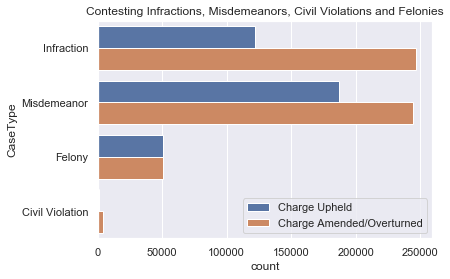

In [110]:
sns.set(style="darkgrid")
ax = sns.countplot(y="CaseType", hue = "Total_Positive", data=df_contested2)
ax.set_title("Contesting Infractions, Misdemeanors, Civil Violations and Felonies")
plt.legend((('Charge Upheld', 'Charge Amended/Overturned')), loc = 'lower right');

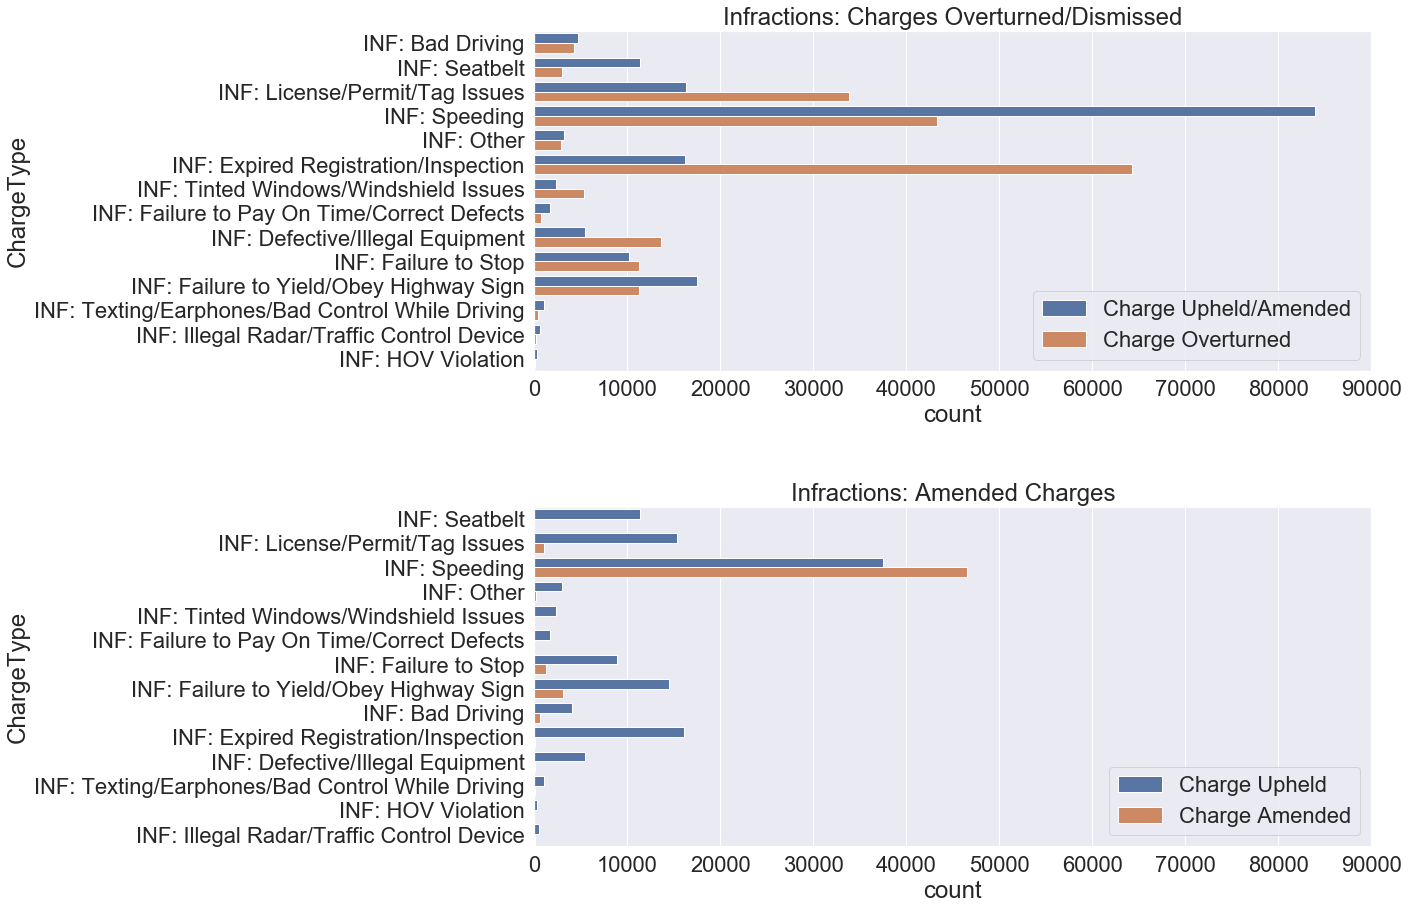

In [111]:
# plotting charge types for infractions
figure, axes = plt.subplots(2, 1, figsize=(15, 15), sharex = True)
sns.set(font_scale=2)
ax1 = plt.subplot(211)
ax1 = sns.countplot(y="ChargeType", hue = "Outcome_Positive", 
                   data=df_contested2[df_contested2['CaseType'] == 'Infraction'])
ax1.set_title("Infractions: Charges Overturned/Dismissed")
ax1.legend((('Charge Upheld/Amended', 'Charge Overturned')), loc = 'lower right')
ax1.set_xlim(0, 90000)

plt.subplots_adjust(hspace = 0.4)

ax2 = plt.subplot(212)
ax2 = sns.countplot(y="ChargeType", hue = "Amended", 
                   data=df_contested2[(df_contested2['CaseType'] == 'Infraction') &
                                     (df_contested2['Outcome_Positive'] == 0)])
ax2.set_title("Infractions: Amended Charges")
ax2.legend((('Charge Upheld', 'Charge Amended')), loc = 'lower right')
ax2.set_xlim(0, 90000);

There are decent odds of getting a case overturned for most types of infractions, with the exception of tickets related to speeding, seatbelts, and failure to obey highway signs. 

A little over half of speeding tickets that are contested (but not dismissed) are amended to a lesser fine. 

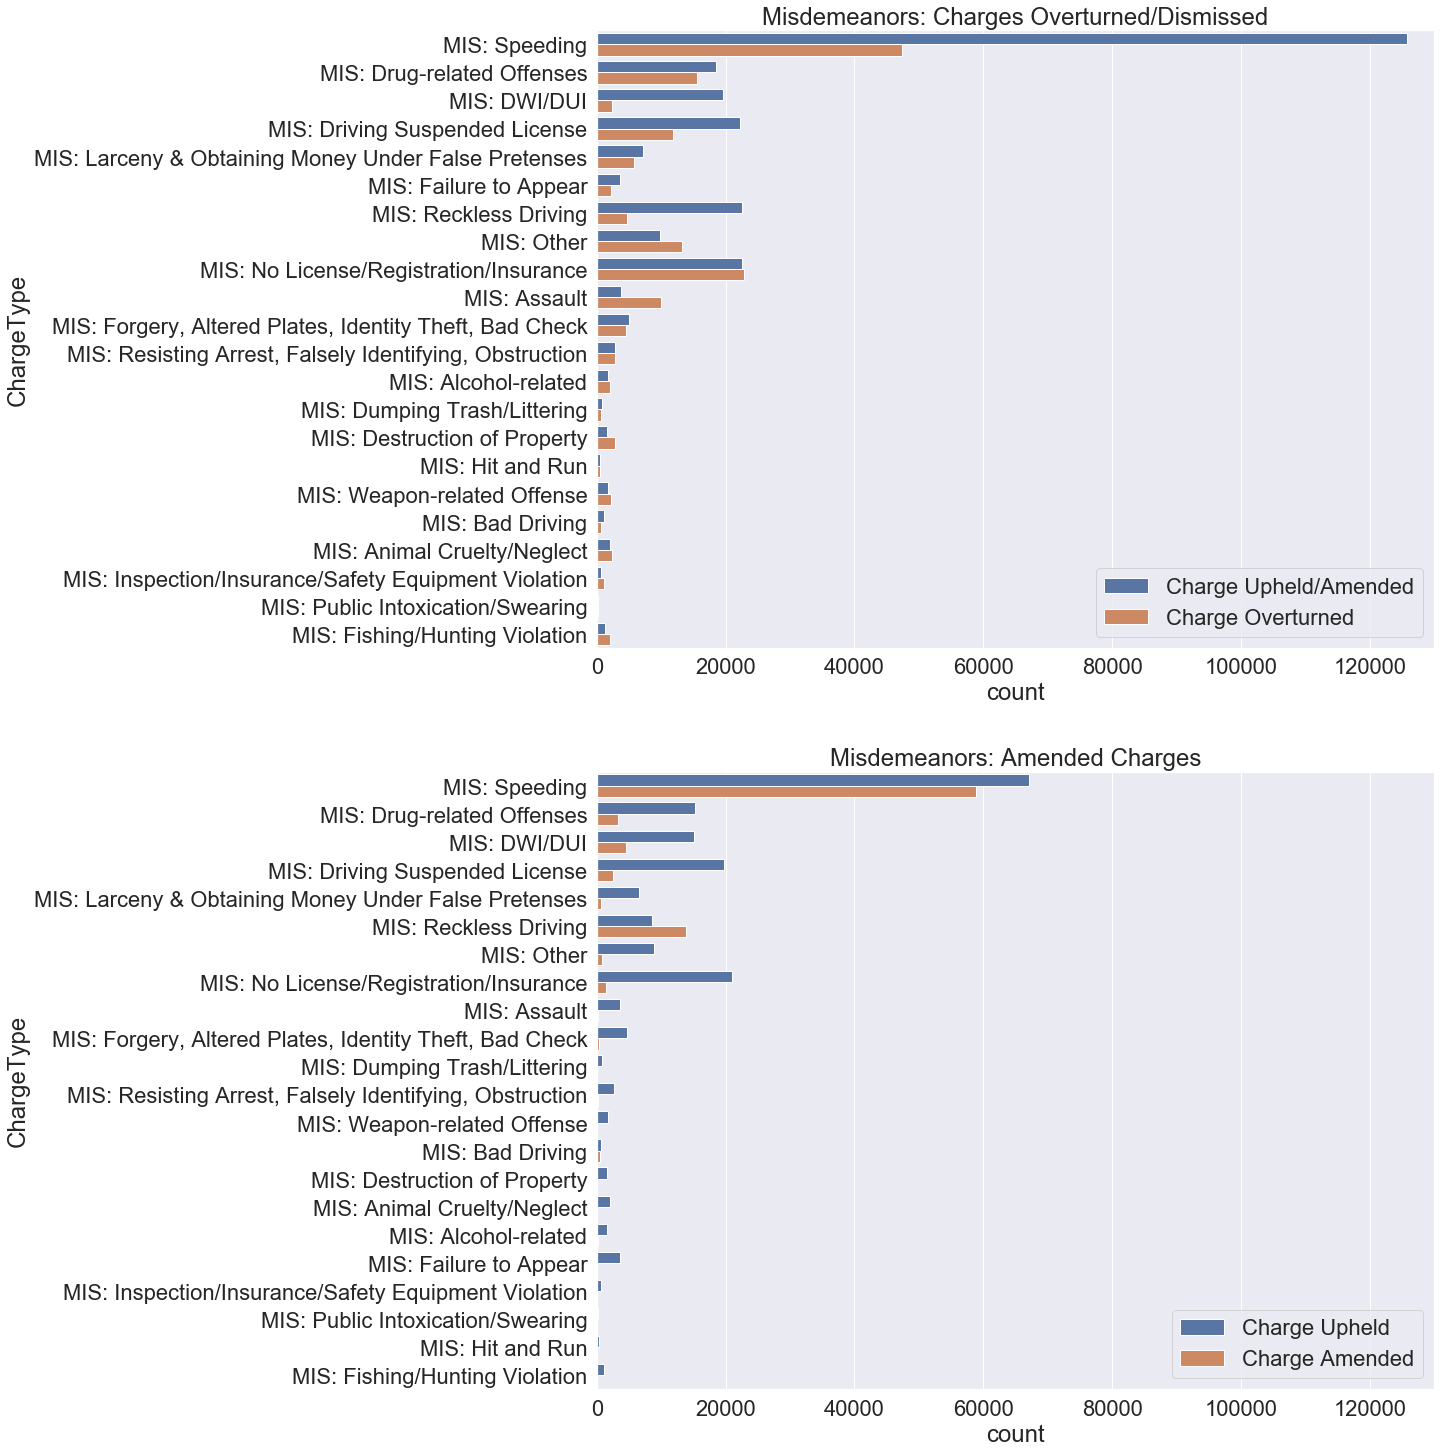

In [112]:
# plotting charge types for misdemeanors
figure, axes = plt.subplots(2, 1, figsize=(15, 25), sharex = True)
sns.set(font_scale=2)
ax1 = plt.subplot(211)
ax1 = sns.countplot(y="ChargeType", hue = "Outcome_Positive", 
                   data=df_contested2[df_contested2['CaseType'] == 'Misdemeanor'])
ax1.set_title("Misdemeanors: Charges Overturned/Dismissed")
ax1.legend((('Charge Upheld/Amended', 'Charge Overturned')), loc = 'lower right')
ax1.set_xlim(0, 130000)

plt.subplots_adjust(hspace = 0.2)

ax2 = plt.subplot(212)
ax2 = sns.countplot(y="ChargeType", hue = "Amended", 
                   data=df_contested2[(df_contested2['CaseType'] == 'Misdemeanor') &
                                     (df_contested2['Outcome_Positive'] == 0)])
ax2.set_title("Misdemeanors: Amended Charges")
ax2.legend((('Charge Upheld', 'Charge Amended')), loc = 'lower right')
ax2.set_xlim(0, 130000);

Misdemeanor charges that are hardest to get overturned are DWI/DUIs, Speeding, Reckless Driving, and driving with a suspended license.

Of those cases that are not dismissed, reckless driving and speeding tickets are amended at higher rates.

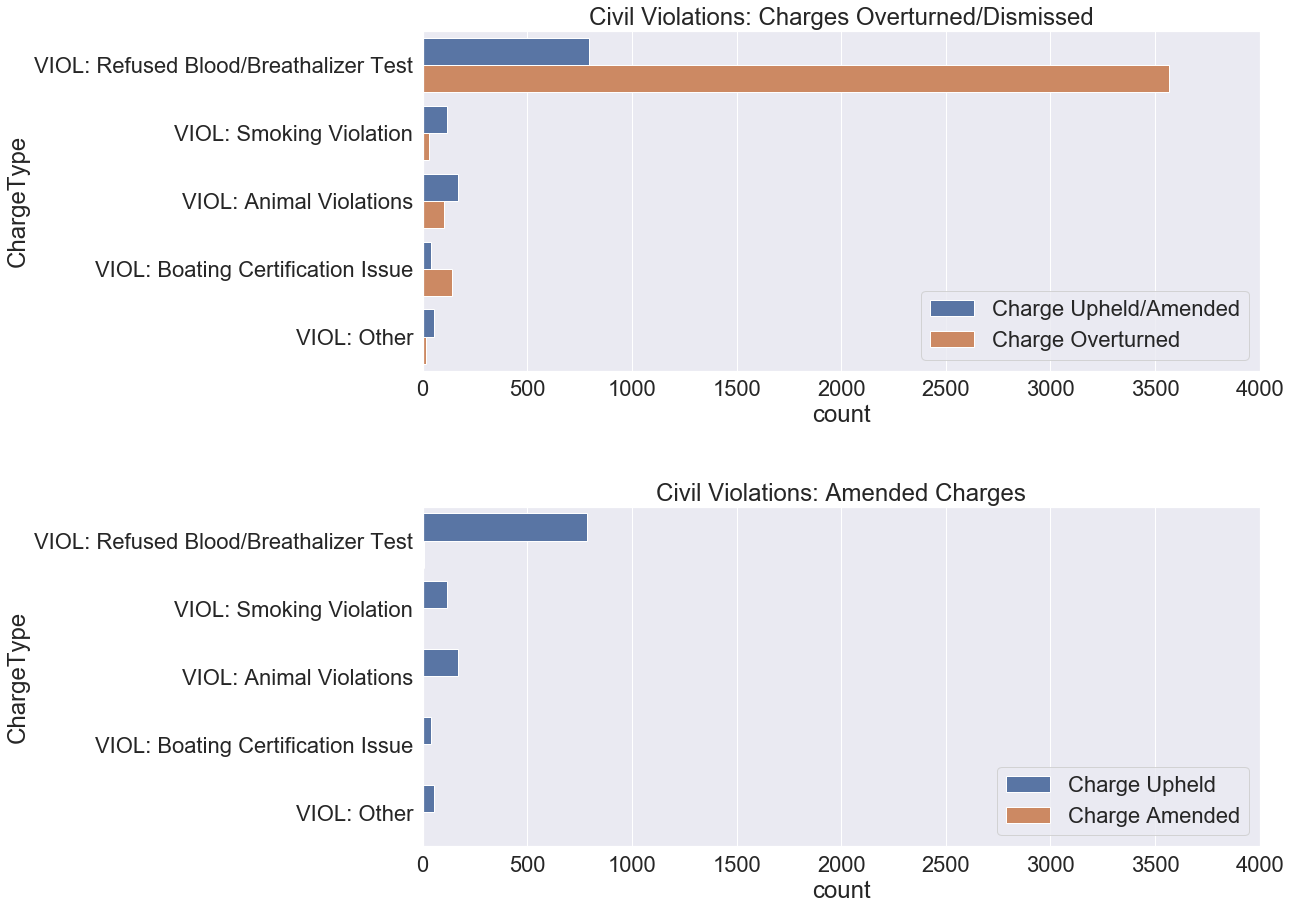

In [113]:
# plotting charge types for civil violations
figure, axes = plt.subplots(2, 1, figsize=(15, 15), sharex = True)
sns.set(font_scale=2)
ax1 = plt.subplot(211)
ax1 = sns.countplot(y="ChargeType", hue = "Outcome_Positive", 
                   data=df_contested2[df_contested2['CaseType'] == 'Civil Violation'])
ax1.set_title("Civil Violations: Charges Overturned/Dismissed")
ax1.legend((('Charge Upheld/Amended', 'Charge Overturned')), loc = 'lower right')
ax1.set_xlim(0, 4000)

plt.subplots_adjust(hspace = 0.4)

ax2 = plt.subplot(212)
ax2 = sns.countplot(y="ChargeType", hue = "Amended", 
                   data=df_contested2[(df_contested2['CaseType'] == 'Civil Violation') &
                                     (df_contested2['Outcome_Positive'] == 0)])
ax2.set_title("Civil Violations: Amended Charges")
ax2.legend((('Charge Upheld', 'Charge Amended')), loc = 'lower right')
ax2.set_xlim(0, 4000);

The majority of tickets for refusing a blood/breathalizer test are overturned, as are tickets related to boating certifications. Very few civil violation charges are amended if they are not overturned.

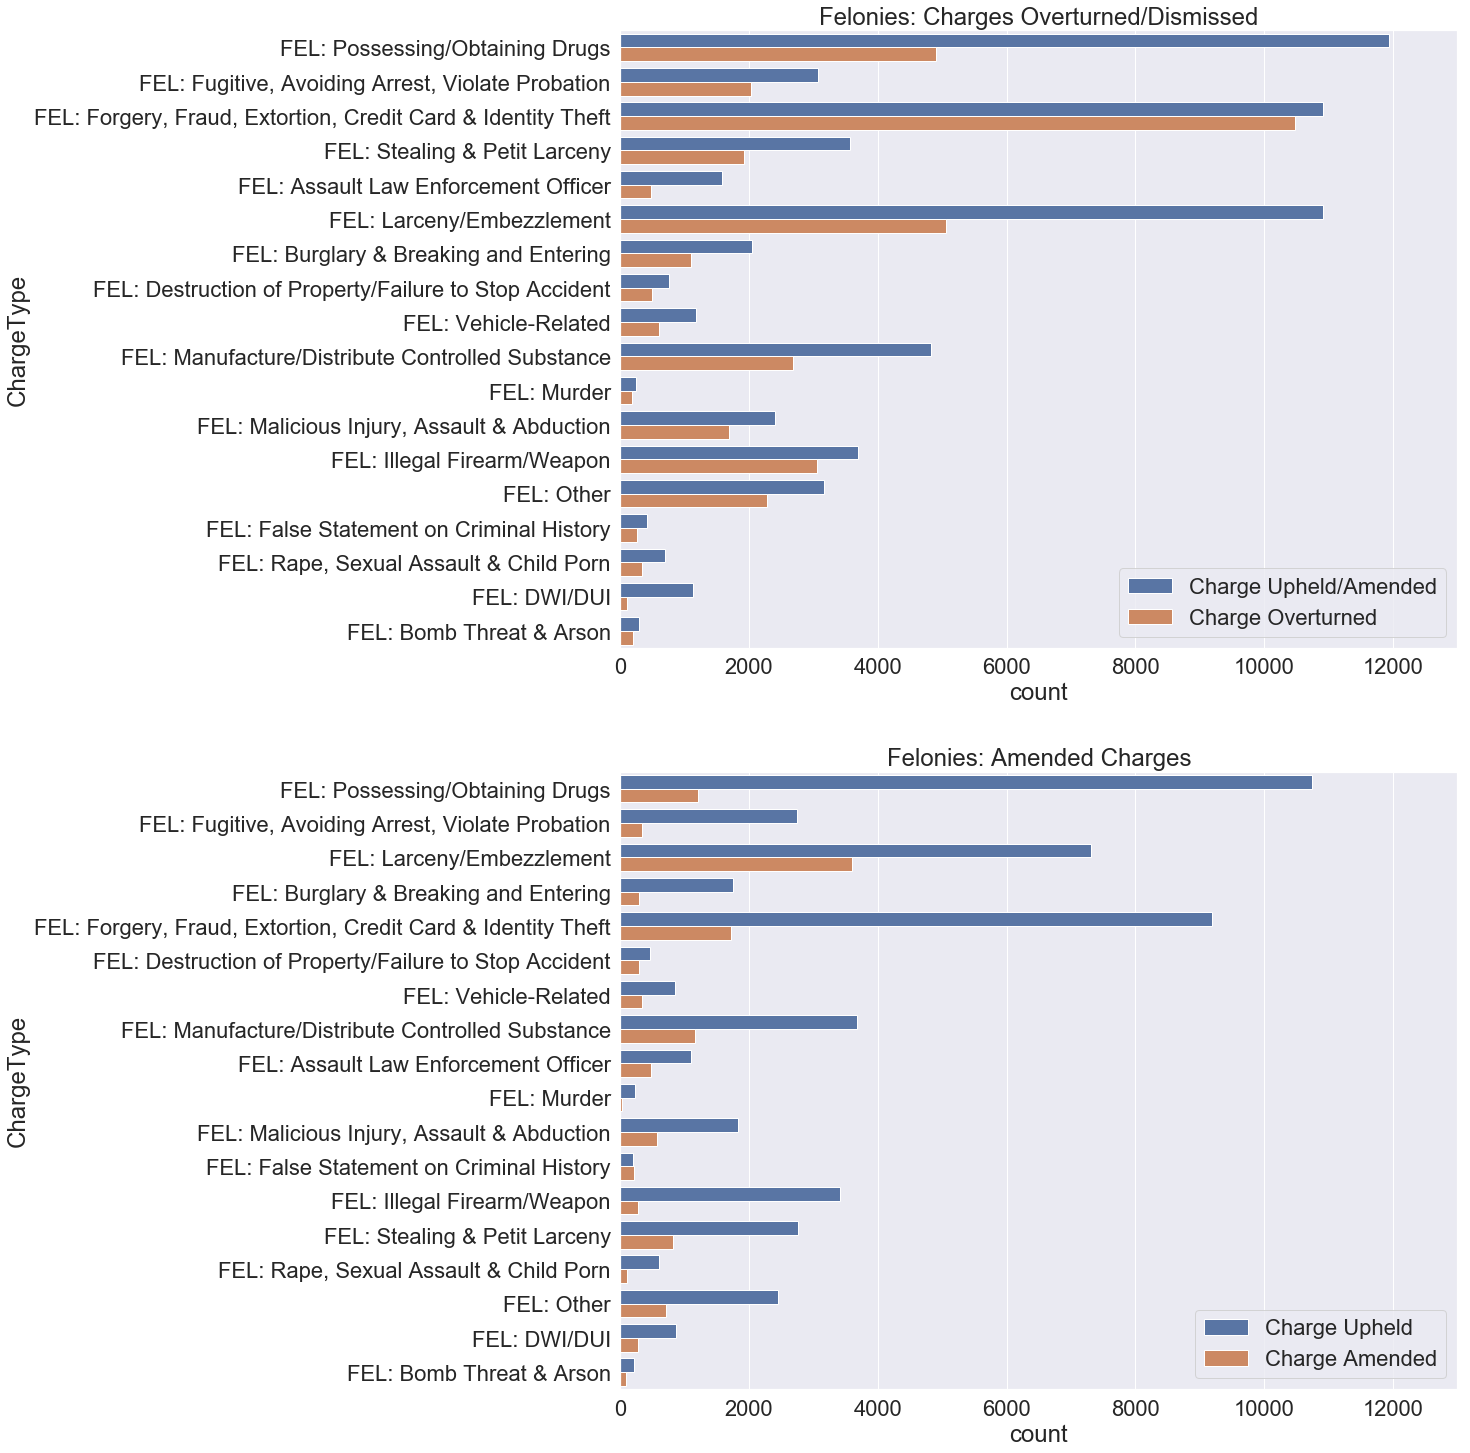

In [114]:
# plotting charge types for felonies
figure, axes = plt.subplots(2, 1, figsize=(15, 25), sharex = True)
sns.set(font_scale=2)
ax1 = plt.subplot(211)
ax1 = sns.countplot(y="ChargeType", hue = "Outcome_Positive", 
                   data=df_contested2[df_contested2['CaseType'] == 'Felony'])
ax1.set_title("Felonies: Charges Overturned/Dismissed")
ax1.legend((('Charge Upheld/Amended', 'Charge Overturned')), loc = 'lower right')
ax1.set_xlim(0, 13000)

plt.subplots_adjust(hspace = 0.2)

ax2 = plt.subplot(212)
ax2 = sns.countplot(y="ChargeType", hue = "Amended", 
                   data=df_contested2[(df_contested2['CaseType'] == 'Felony') &
                                     (df_contested2['Outcome_Positive'] == 0)])
ax2.set_title("Felonies: Amended Charges")
ax2.legend((('Charge Upheld', 'Charge Amended')), loc = 'lower right')
ax2.set_xlim(0, 13000);

There is a surprisingly good chance of getting charges related to forgery/ fraud/ extortion/ credit card and identity theft dismissed or overturned (almost 50%). It would be interesting to break this category down further and see if there's more of a difference by specific charge (and if some of these are considered white-collar crimes, could we extrapolate that hiring more expensive lawyers might be helping the defendants' odds here?)

3. How much do districts/counties vary in their expected outcomes? 

In [115]:
# pretty significant spread of outcomes just looking at county level
df_contested.groupby('Court')['Outcome_Positive'].value_counts(normalize = True).sort_values().head()

Court               Outcome_Positive
Greensville County  1                   0.057782
Brunswick County    1                   0.086060
Sussex County       1                   0.131493
Madison County      1                   0.233095
Emporia City        1                   0.234787
Name: Outcome_Positive, dtype: float64

Counties making up the very middle (right around 50% odds of upholding/rejecting charges) are Bedford County, Galax City, Charles City County, Pittsylvania County, and Rockingham County.

4. Are there clear disparities in outcomes based on race?

Quick comparison of demographics of caseload in 2017 compared to Virginia demographics (taken from Census.gov: https://www.census.gov/quickfacts/va#qf-headnote-b)

In [116]:
df_full['Race'].value_counts(normalize = True)

White Caucasian(Non-Hispanic)              0.601519
Black(Non-Hispanic)                        0.316946
Hispanic                                   0.032688
Other(Includes Not Applicable, Unknown)    0.028385
Asian Or Pacific Islander                  0.018823
American Indian                            0.001640
Name: Race, dtype: float64

In [117]:
census_compare = [
                 ['White Caucasian (Non-Hispanic)', '62%', '60%'],
                 ['Black (Non-Hispanic)', '20%', '32%'],
                 ['Hispanic', '9%', '3%'],
                ['Asian Or Pacific Islander', '7%', '2%'],
                  ['American Indian', '.05%', '.02%'],
                 ['Other(Includes Not Applicable, Unknown)', '1.5%', '2.7%']
]

df_census_compare = pd.DataFrame(census_compare, 
                                 columns = ['Race/Ethnicity', '2017 Census Percentage', 
                                            '2017 Criminal Hearing Percentage'])

In [118]:
df_census_compare

,Race/Ethnicity,2017 Census Percentage,2017 Criminal Hearing Percentage
0,White Caucasian (Non-Hispanic),62%,60%
1,Black (Non-Hispanic),20%,32%
2,Hispanic,9%,3%
3,Asian Or Pacific Islander,7%,2%
4,American Indian,.05%,.02%
5,"Other(Includes Not Applicable, Unknown)",1.5%,2.7%


The above comparison shows some differences in the demographic makeup of Virginia according to 2017 Census estimates and the demographic makeup of defendants during hearings in 2017. (This disparity could be indicative of racial bias in how crimes are defined, prosecuted, and punished but we don't have enough information to draw strong conclusions about what's driving this disparity and at what point in the criminal justice process.)

In [119]:
df_contested.groupby('Race')['Outcome_Positive'].value_counts(normalize = True)

Race                                     Outcome_Positive
American Indian                          0                   0.587931
                                         1                   0.412069
Asian Or Pacific Islander                0                   0.550711
                                         1                   0.449289
Black(Non-Hispanic)                      0                   0.579487
                                         1                   0.420513
Hispanic                                 0                   0.694374
                                         1                   0.305626
Other(Includes Not Applicable, Unknown)  0                   0.629179
                                         1                   0.370821
White Caucasian(Non-Hispanic)            0                   0.544953
                                         1                   0.455047
Name: Outcome_Positive, dtype: float64

In [120]:
df_contested.groupby('Race')['Amended'].value_counts(normalize = True)

Race                                     Amended
American Indian                          0          0.719828
                                         1          0.280172
Asian Or Pacific Islander                0          0.777884
                                         1          0.222116
Black(Non-Hispanic)                      0          0.853805
                                         1          0.146195
Hispanic                                 0          0.853995
                                         1          0.146005
Other(Includes Not Applicable, Unknown)  0          0.740811
                                         1          0.259189
White Caucasian(Non-Hispanic)            0          0.835515
                                         1          0.164485
Name: Amended, dtype: float64

Looking at the outcomes of contested cases, Latino defendants are least likely to be found not guilty or have charges dismissed. The odds are a little more even with getting an amended charge. However, it would be more robust to compare outcomes with all other features held equal (ex. the charge and county.)

5. Are there clear disparities in outcomes based on gender?

In [121]:
df_contested.groupby('Gender')['Outcome_Positive'].value_counts(normalize = True)

Gender  Outcome_Positive
Female  0                   0.535905
        1                   0.464095
Male    0                   0.578360
        1                   0.421640
Name: Outcome_Positive, dtype: float64

In [122]:
df_contested.groupby('Gender')['Amended'].value_counts(normalize = True)

Gender  Amended
Female  0          0.826834
        1          0.173166
Male    0          0.844718
        1          0.155282
Name: Amended, dtype: float64

Women are slightly more likely to have charges dismissed/found not guilty or amended than men.

In [123]:
df_full.groupby('Gender')['Contested'].value_counts(normalize = True)

Gender  Contested
Female  0            0.525919
        1            0.474081
Male    1            0.528490
        0            0.471510
Name: Contested, dtype: float64

In [124]:
df_full['Gender'].value_counts(normalize = True)

Male      0.649252
Female    0.350748
Name: Gender, dtype: float64

Women and men contest charges at about the same rate in Virginia, but there are substantially more men who are charged with crimes.

6. For charges which are optional to go to court for, is there a clear difference in outcome (compared to more serious charges?)

In [125]:
df_contested['HadLawyer'].value_counts(normalize = True)

0    0.581705
1    0.418295
Name: HadLawyer, dtype: float64

In [126]:
df_contested[df_contested['HadLawyer'] ==1]['PublicDefender'].value_counts(normalize = True)

0    0.824966
1    0.175034
Name: PublicDefender, dtype: float64

41% of the defendants in the database who contested their charges had lawyers (that we know of); of those with lawyers, 11% had public defenders.

In [127]:
df_contested.groupby('HadLawyer')['Outcome_Positive'].value_counts(normalize = True)

HadLawyer  Outcome_Positive
0          0                   0.526850
           1                   0.473150
1          0                   0.616862
           1                   0.383138
Name: Outcome_Positive, dtype: float64

Cases where defendants didn't have lawyers had a higher rate of success (in terms of being dismissed/found not guilty) than cases with lawyers. This could be due to lawyers being involved more frequently with more serious cases.

In [128]:
df_contested.groupby('PublicDefender')['Outcome_Positive'].value_counts(normalize = True)

PublicDefender  Outcome_Positive
0               0                   0.559868
                1                   0.440132
1               0                   0.623163
                1                   0.376837
Name: Outcome_Positive, dtype: float64

Cases where defendants hired public defenders instead of private lawyers had slightly worse odds of success.